## Importando os pacotes básicos necessários para análise

In [1]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

### Credenciando o acesso à API

In [2]:
# Declare the credentials
cid = 'CID'
secret = 'SECRET'
redirect_uri='http://localhost:7777/callback'
username = '11135142256'

# Authorization flow
scope = 'user-top-read'
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

### Definindo as funções que gerarão os dados para análise

In [3]:
def get_top_songs(limit = 20, offset = 0, time_range = 'short_term'):
    
    '''
    INPUT:
    limit - (int) - quantidade de músicas que você quer que a função retorne
    offset -  "the index of the first item to return" de acordo com a documentação do Spotipy
    time_range: pode ser 'short_term', 'medium_term' ou 'long_term'
    
    OUTPUT:
    top_songs - um dicionário com os ids das top limit músicas definidas pelo usuário
    
    Description:
    Essa função gera um dicionário com as top n (n é definido pelo argumento limit) músicas e seus ids
    
    '''
    
    top_tracks = sp.current_user_top_tracks(limit=limit, offset=offset, time_range=time_range)
    
    top_songs = {}
    for i in range(len(top_tracks['items'])):
        top_songs[i] = (top_tracks['items'][i]['id'])
        
    return top_songs


def df_song_features(top_songs):
    
    '''
    INPUT:
    top_songs - um dicionário com os ids das top limit músicas definidas pelo usuário -
    recomendado utilizar a função get_top_songs para gerar esse dicionário
    
    OUTPUT:
    df um dataframe com informações de cada uma das músicas - audio features, artista, nome da música, ids,
    entre outros
    
    Description:
    Essa função gera um dataframe em que cada linha representa uma música e cada coluna são features
    que descrevem as músicas - inclui as "audio features" geradas pelo Spotify
    
    '''
    
    features_list = []
    for i in range(len(top_songs)):
        features = sp.audio_features([top_songs[i]])
        features = features[0]
        features['song_name'] = sp.track(top_songs[i])['name']
        features['artist'] = sp.track(top_songs[i])['artists'][0]['name']
        features['artist_id'] = sp.track(top_songs[i])['artists'][0]['id']
        features['genre'] = sp.artist(sp.track(top_songs[i])['artists'][0]['id'])['genres']
        features_list.append(features)
    
    features_dict = {}
    for k in features_list[0]:
        features_dict[k] = [d[k] for d in features_list]
    
    df = pd.DataFrame.from_dict(features_dict)

    
    return df


### Explorando e validando os resultados das funções

In [4]:
time_ranges = ['short_term', 'medium_term', 'long_term']

In [5]:
dfs = []
for time_range in time_ranges:
    top_songs = get_top_songs(limit = 50, offset = 0, time_range = time_range)
    df = df_song_features(top_songs)
    dfs.append(df)
    

In [6]:
df = pd.concat([dfs[0],dfs[1],dfs[2]])

In [7]:
df.shape

(150, 22)

In [8]:
df_copy = df.copy()

In [9]:
main_features = ['danceability', 'energy', 'loudness', 'acousticness', 
                 'instrumentalness', 'valence', 'tempo']

In [10]:
df[main_features].describe()

,danceability,energy,loudness,acousticness,instrumentalness,valence,tempo
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.461153,0.729881,-7.055847,0.167665,0.174934,0.374217,122.200300
std,0.142387,0.238238,3.200551,0.292210,0.291972,0.218195,29.307277
min,0.159000,0.070100,-20.191000,0.000003,0.000000,0.036400,63.425000
25%,0.368750,0.567750,-9.043250,0.000323,0.000057,0.195250,97.015000
50%,0.462000,0.792500,-6.212500,0.007545,0.003385,0.331500,123.008000
75%,0.557000,0.936000,-4.568000,0.163500,0.175000,0.523000,143.646000
max,0.865000,0.993000,-2.518000,0.970000,0.956000,0.925000,199.991000


### Visualizações

In [11]:
df_copy.groupby('key').count().reset_index()

,key,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,song_name,artist,artist_id,genre
0,0,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
1,1,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
2,2,26,26,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26
3,3,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
4,4,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
5,5,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
6,6,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
7,7,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
8,8,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
9,9,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20


Text(0.5, 1.0, 'Contagem do número de músicas por tom')

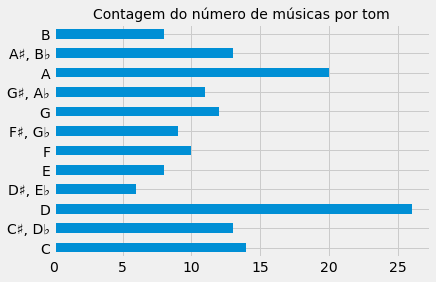

In [12]:
plt.style.use('fivethirtyeight')

labels = ['C', 'C♯, D♭', 'D', 'D♯, E♭', 'E', 'F', 'F♯, G♭', 'G', 'G♯, A♭', 'A', 'A♯, B♭', 'B']

ax = df_copy.groupby('key').count().reset_index()['energy'].plot.barh();

ax.set_yticklabels(labels);

ax.set_title('Contagem do número de músicas por tom', fontsize = 14)

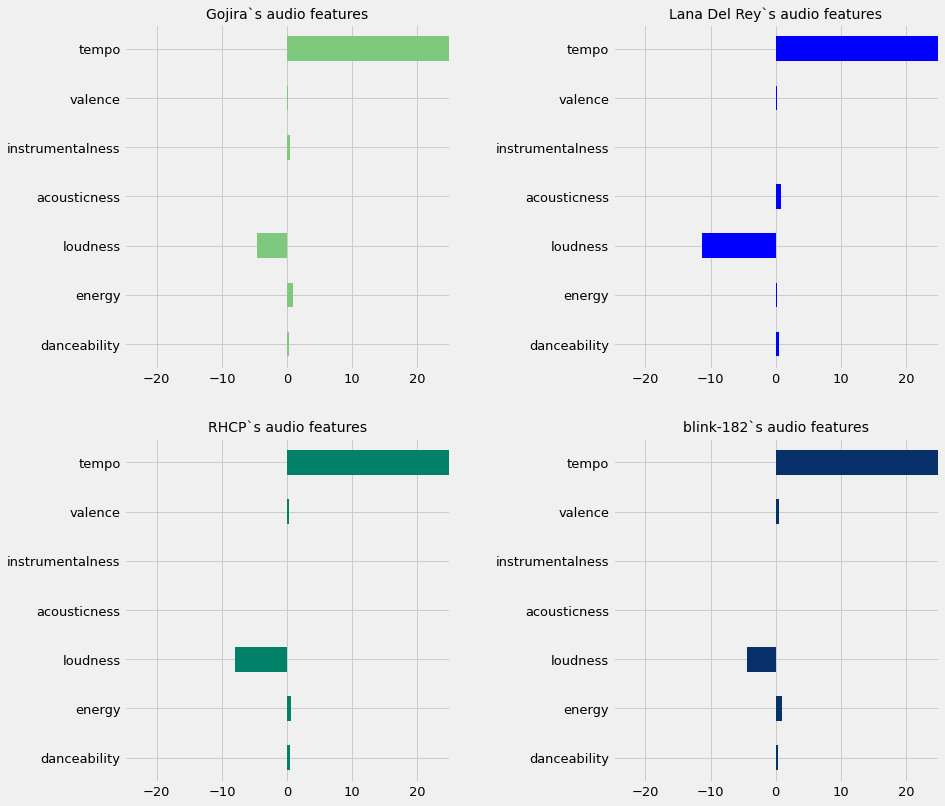

In [13]:
plt.style.use('fivethirtyeight')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 13))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.2, wspace=.5)

# top left
df_copy.query('artist == "Gojira"')[main_features].mean().plot.barh(ax=ax1, colormap=plt.cm.Accent, fontsize=13)
ax1.set_xlim(-25,25)

# top right
df_copy.query('artist == "Lana Del Rey"')[main_features].mean().plot.barh(ax=ax2, colormap='winter', fontsize=13)
ax2.set_xlim(-25,25)

# bottom left
df_copy.query('artist == "Red Hot Chili Peppers"')[main_features].mean().plot.barh(ax=ax3, colormap='summer', fontsize=13)
ax3.set_xlim(-25,25)

# bottom right
df_copy.query('artist == "blink-182"')[main_features].mean().plot.barh(ax=ax4, colormap='Blues_r', fontsize=13)
ax4.set_xlim(-25,25)

ax1.set_title('Gojira`s audio features', fontsize = 14)
ax2.set_title('Lana Del Rey`s audio features', fontsize = 14)
ax3.set_title('RHCP`s audio features', fontsize = 14)
ax4.set_title('blink-182`s audio features', fontsize = 14)

plt.show()

Variáveis com unidades em diferentes escalas - precisamos padronizar para fazermos uma análise coerente

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df[main_features] = scaler.fit_transform(df[main_features])

In [15]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,song_name,artist,artist_id,genre
0,1.499856,-0.391171,10,-1.351516,0,0.0386,-0.575338,1.831864,0.1070,-0.957464,...,09SvE4RSe1Unl1Ta2Fj98N,spotify:track:09SvE4RSe1Unl1Ta2Fj98N,https://api.spotify.com/v1/tracks/09SvE4RSe1Un...,https://api.spotify.com/v1/audio-analysis/09Sv...,393138,4,Burning,King Buffalo,06D0YfeNZgBA7XWQ79Y42R,"[instrumental stoner rock, psychedelic doom, r..."
1,0.703585,0.147907,6,-0.821399,0,0.0341,-0.321614,1.608494,0.8840,-0.985055,...,4CMObZi8wKUSruORHR33Ur,spotify:track:4CMObZi8wKUSruORHR33Ur,https://api.spotify.com/v1/tracks/4CMObZi8wKUS...,https://api.spotify.com/v1/audio-analysis/4CMO...,621114,4,Acheron,King Buffalo,06D0YfeNZgBA7XWQ79Y42R,"[instrumental stoner rock, psychedelic doom, r..."
2,-0.987612,-0.782845,2,-0.038608,1,0.0364,0.430357,-0.601115,0.1100,-0.419451,...,7ycz6sgZWp4wvF53BZVTjE,spotify:track:7ycz6sgZWp4wvF53BZVTjE,https://api.spotify.com/v1/tracks/7ycz6sgZWp4w...,https://api.spotify.com/v1/audio-analysis/7ycz...,398267,3,Scene Eight: The Spirit Carries On,Dream Theater,2aaLAng2L2aWD2FClzwiep,"[metal, progressive metal, rock]"
3,1.048871,-0.028978,2,-0.892249,1,0.0418,-0.575573,0.835289,0.0413,0.334687,...,2y9Me04be6zHla3lLtgRdr,spotify:track:2y9Me04be6zHla3lLtgRdr,https://api.spotify.com/v1/tracks/2y9Me04be6zH...,https://api.spotify.com/v1/audio-analysis/2y9M...,270927,3,Hebetation,King Buffalo,06D0YfeNZgBA7XWQ79Y42R,"[instrumental stoner rock, psychedelic doom, r..."
4,0.076433,0.779638,2,0.693398,1,0.0401,-0.575358,1.852483,0.1330,-0.171137,...,6PhrbFbRW3Cchrv6klsLF5,spotify:track:6PhrbFbRW3Cchrv6klsLF5,https://api.spotify.com/v1/tracks/6PhrbFbRW3Cc...,https://api.spotify.com/v1/audio-analysis/6Phr...,240359,4,Sphinx,Gojira,0GDGKpJFhVpcjIGF8N6Ewt,"[alternative metal, french death metal, french..."


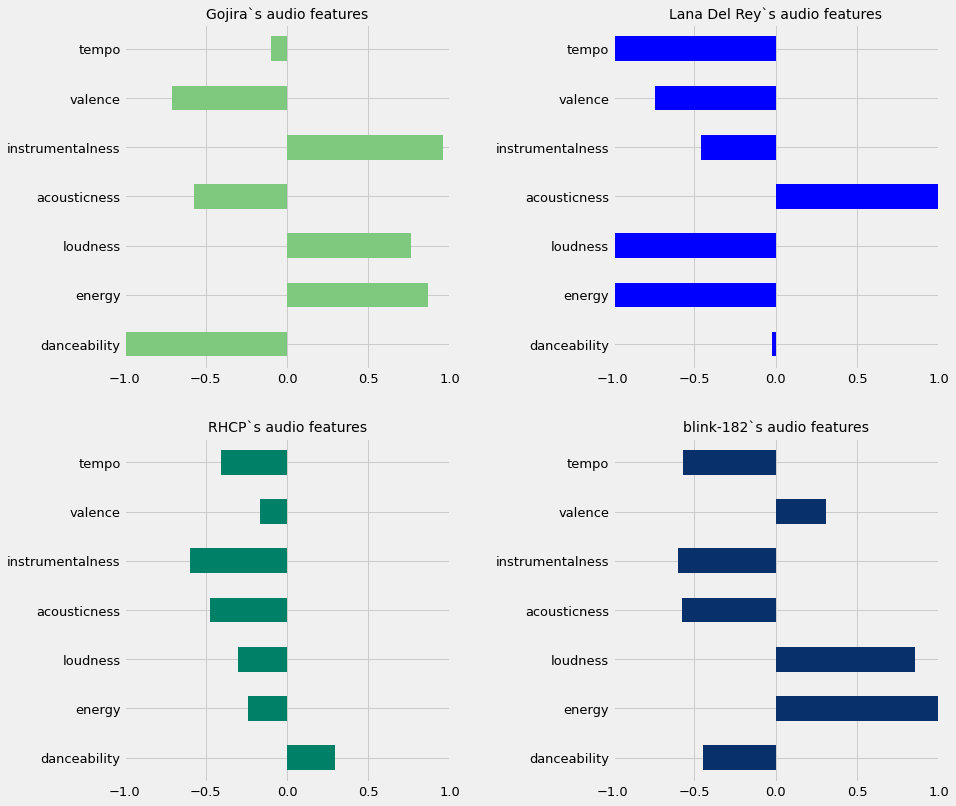

In [16]:
plt.style.use('fivethirtyeight')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 13))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.2, wspace=.5)

# top left
df.query('artist == "Gojira"')[main_features].mean().plot.barh(ax=ax1, colormap=plt.cm.Accent, fontsize=13)
ax1.set_xlim(-1,1)

# top right
df.query('artist == "Lana Del Rey"')[main_features].mean().plot.barh(ax=ax2, colormap='winter', fontsize=13)
ax2.set_xlim(-1,1)

# bottom left
df.query('artist == "Red Hot Chili Peppers"')[main_features].mean().plot.barh(ax=ax3, colormap='summer', fontsize=13)
ax3.set_xlim(-1,1)

# bottom right
df.query('artist == "blink-182"')[main_features].mean().plot.barh(ax=ax4, colormap='Blues_r', fontsize=13)
ax4.set_xlim(-1,1)

ax1.set_title('Gojira`s audio features', fontsize = 14)
ax2.set_title('Lana Del Rey`s audio features', fontsize = 14)
ax3.set_title('RHCP`s audio features', fontsize = 14)
ax4.set_title('blink-182`s audio features', fontsize = 14)

plt.show()

## Machine learning time

##### Para usarmos o algoritmo de clusterização precisamos reduzir a dimensionalidade do nosso espaço de features para 2D - para tanto usaremos PCA

In [17]:
from sklearn.decomposition import PCA
pca = PCA(2)
 
#Transform the data
df_r = pca.fit_transform(df[main_features])

##### Para clusterizar usaremos o algoritmo Kmeans

In [18]:
#######
from sklearn.cluster import KMeans

In [19]:
### Encontrando o número ótimo de clusters usando a regra do cotovelo

kmeans_kwargs = {
"init": "random",
"n_init": 10,
"max_iter": 300,
"random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_r)
    sse.append(kmeans.inertia_)

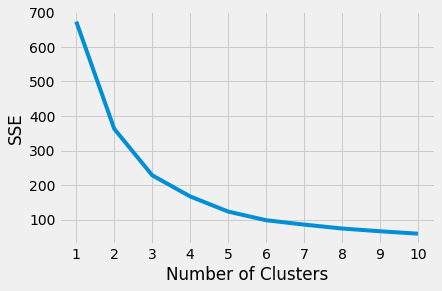

In [20]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Usaremos 5 clusters de acordo com a regra do cotovelo
    
 

In [21]:
#######

kmeans = KMeans(
        init="random",
        n_clusters=6,
        n_init=10,
        max_iter=300,
        random_state=42
)

kmeans.fit(df_r)

KMeans(init='random', n_clusters=6, random_state=42)

In [22]:
label = kmeans.fit_predict(df_r)

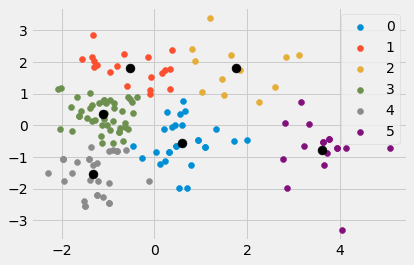

In [23]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df_r[label == i , 0] , df_r[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [24]:
df['cluster'] = kmeans.labels_

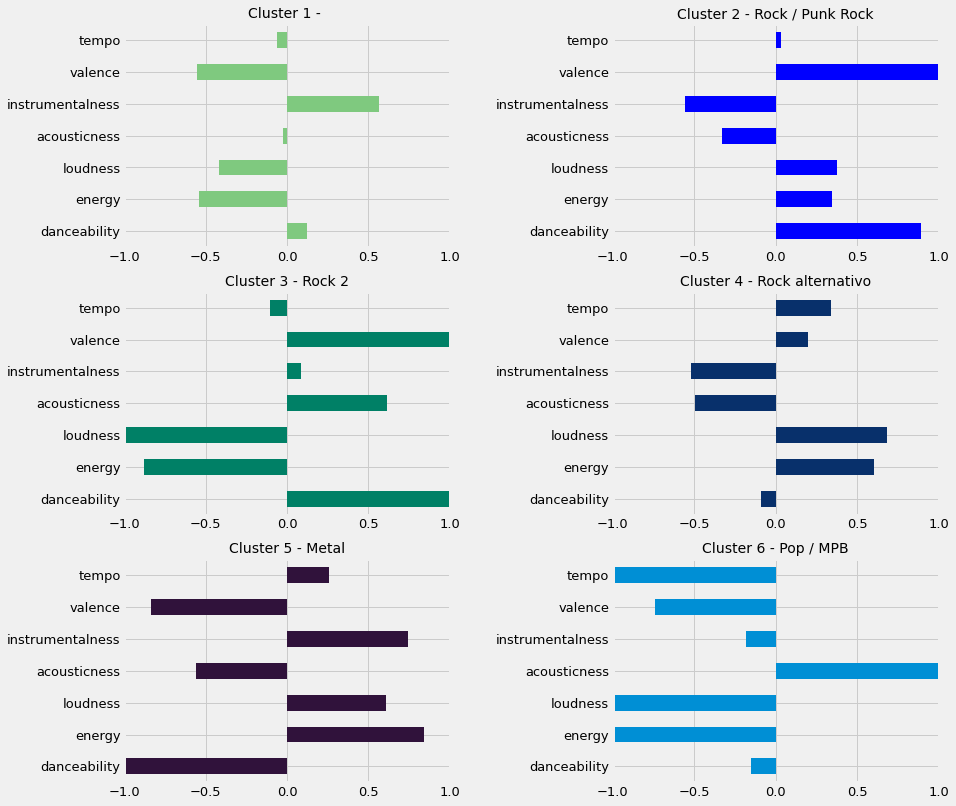

In [25]:
plt.style.use('fivethirtyeight')

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13, 13))

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

#fig.delaxes(axes[2,1]) #The indexing is zero-based here

fig.subplots_adjust(hspace=.2, wspace=.5)

# top left
df.query('cluster == 0')[main_features].mean().plot.barh(ax=ax1, colormap=plt.cm.Accent, fontsize=13)
ax1.set_xlim(-1,1)

# top right
df.query('cluster == 1')[main_features].mean().plot.barh(ax=ax2, colormap='winter', fontsize=13)
ax2.set_xlim(-1,1)

# bottom left
df.query('cluster == 2')[main_features].mean().plot.barh(ax=ax3, colormap='summer', fontsize=13)
ax3.set_xlim(-1,1)

# bottom right
df.query('cluster == 3')[main_features].mean().plot.barh(ax=ax4, colormap='Blues_r', fontsize=13)
ax4.set_xlim(-1,1)

# bottom right
df.query('cluster == 4')[main_features].mean().plot.barh(ax=ax5, colormap='turbo', fontsize=13)
ax5.set_xlim(-1,1)

df.query('cluster == 5')[main_features].mean().plot.barh(ax=ax6, fontsize=13)
ax6.set_xlim(-1,1)

ax1.set_title('Cluster 1 - ', fontsize = 14)
ax2.set_title('Cluster 2 - Rock / Punk Rock', fontsize = 14)
ax3.set_title('Cluster 3 - Rock 2', fontsize = 14)
ax4.set_title('Cluster 4 - Rock alternativo', fontsize = 14)
ax5.set_title('Cluster 5 - Metal', fontsize = 14)
ax6.set_title('Cluster 6 - Pop / MPB', fontsize = 14)


plt.show()

## Cluster analysis

#### Cluster 1:

- Slow

- Somewhat acoustic

- Very low valence (sound sad and angry)

- Low energy

- Not loud


In [26]:
df.query('cluster == 0')

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,song_name,artist,artist_id,genre,cluster
0,1.499856,-0.391171,10,-1.351516,0,0.0386,-0.575338,1.831864,0.1070,-0.957464,...,spotify:track:09SvE4RSe1Unl1Ta2Fj98N,https://api.spotify.com/v1/tracks/09SvE4RSe1Un...,https://api.spotify.com/v1/audio-analysis/09Sv...,393138,4,Burning,King Buffalo,06D0YfeNZgBA7XWQ79Y42R,"[instrumental stoner rock, psychedelic doom, r...",0
1,0.703585,0.147907,6,-0.821399,0,0.0341,-0.321614,1.608494,0.8840,-0.985055,...,spotify:track:4CMObZi8wKUSruORHR33Ur,https://api.spotify.com/v1/tracks/4CMObZi8wKUS...,https://api.spotify.com/v1/audio-analysis/4CMO...,621114,4,Acheron,King Buffalo,06D0YfeNZgBA7XWQ79Y42R,"[instrumental stoner rock, psychedelic doom, r...",0
2,-0.987612,-0.782845,2,-0.038608,1,0.0364,0.430357,-0.601115,0.1100,-0.419451,...,spotify:track:7ycz6sgZWp4wvF53BZVTjE,https://api.spotify.com/v1/tracks/7ycz6sgZWp4w...,https://api.spotify.com/v1/audio-analysis/7ycz...,398267,3,Scene Eight: The Spirit Carries On,Dream Theater,2aaLAng2L2aWD2FClzwiep,"[metal, progressive metal, rock]",0
3,1.048871,-0.028978,2,-0.892249,1,0.0418,-0.575573,0.835289,0.0413,0.334687,...,spotify:track:2y9Me04be6zHla3lLtgRdr,https://api.spotify.com/v1/tracks/2y9Me04be6zH...,https://api.spotify.com/v1/audio-analysis/2y9M...,270927,3,Hebetation,King Buffalo,06D0YfeNZgBA7XWQ79Y42R,"[instrumental stoner rock, psychedelic doom, r...",0
12,0.689491,-0.370113,2,-1.260603,1,0.0503,-0.557610,1.196118,0.1060,0.003602,...,spotify:track:105UzCP1C1laJEheyU2xp9,https://api.spotify.com/v1/tracks/105UzCP1C1la...,https://api.spotify.com/v1/audio-analysis/105U...,387056,3,Locusts,King Buffalo,06D0YfeNZgBA7XWQ79Y42R,"[instrumental stoner rock, psychedelic doom, r...",0
16,0.323065,0.084733,3,-0.545212,1,0.0508,-0.060656,2.261422,0.0836,0.799126,...,spotify:track:2yWCmDy74d92mKcOYP3cZX,https://api.spotify.com/v1/tracks/2yWCmDy74d92...,https://api.spotify.com/v1/audio-analysis/2yWC...,565717,4,Zephyr,King Buffalo,06D0YfeNZgBA7XWQ79Y42R,"[instrumental stoner rock, psychedelic doom, r...",0
26,-1.234245,-0.576479,5,-0.960904,1,0.0442,-0.320928,0.670339,0.0803,-1.359365,...,spotify:track:549IprPsrPiQZVZRhp8JFD,https://api.spotify.com/v1/tracks/549IprPsrPiQ...,https://api.spotify.com/v1/audio-analysis/549I...,394337,3,Orion,King Buffalo,06D0YfeNZgBA7XWQ79Y42R,"[instrumental stoner rock, psychedelic doom, r...",0
29,-1.339944,-0.445921,7,0.101210,0,0.0309,-0.472352,-0.590157,0.0737,-0.607986,...,spotify:track:0il7xIzXf94gNmYw2tnsUI,https://api.spotify.com/v1/tracks/0il7xIzXf94g...,https://api.spotify.com/v1/audio-analysis/0il7...,485018,4,Stairway to Heaven,Mastodon,1Dvfqq39HxvCJ3GvfeIFuT,"[alternative metal, atlanta metal, hard rock, ...",0
37,0.428765,-1.279807,0,-0.121997,1,0.0242,-0.211737,1.715024,0.2240,-0.322885,...,spotify:track:0wcEUeOslMI8dPB7QjUMiW,https://api.spotify.com/v1/tracks/0wcEUeOslMI8...,https://api.spotify.com/v1/audio-analysis/0wcE...,244200,4,All I Want Is to Be With You,John Mayer,0hEurMDQu99nJRq8pTxO14,"[neo mellow, pop rock, singer-songwriter]",0
39,1.288457,-0.028978,9,-1.151507,1,0.0527,-0.575135,1.855919,0.0578,0.408262,...,spotify:track:0I1RX1s7wITTeR0BKVIHN4,https://api.spotify.com/v1/tracks/0I1RX1s7wITT...,https://api.spotify.com/v1/audio-analysis/0I1R...,317687,3,Grifter,King Buffalo,06D0YfeNZgBA7XWQ79Y42R,"[instrumental stoner rock, psychedelic doom, r...",0


#### Cluster 2:

- Danceable tracks

- Not acoustic

- Very high valence (sound joyful)

- Medium energetic

- Loud


In [27]:
df.query('cluster == 1').head(15)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,song_name,artist,artist_id,genre,cluster
42,1.098197,0.918619,0,0.039452,1,0.0760,-0.574857,-0.601032,0.0714,1.994711,...,spotify:track:1qjQdtmyTlKMeAcp5a4lD5,https://api.spotify.com/v1/tracks/1qjQdtmyTlKM...,https://api.spotify.com/v1/audio-analysis/1qjQ...,117933,4,Cabeça de bode,Raimundos,3CfJckVRuukdJSvK3r89yJ,"[brazilian punk, brazilian punk rock, brazilia...",1
0,1.520996,-0.071094,4,0.134754,1,0.0288,-0.535531,-0.085684,0.0952,1.700413,...,spotify:track:4Szq4dulKN9bOvLRW6uMdZ,https://api.spotify.com/v1/tracks/4Szq4dulKN9b...,https://api.spotify.com/v1/audio-analysis/4Szq...,159133,4,Carry Me Away,John Mayer,0hEurMDQu99nJRq8pTxO14,"[neo mellow, pop rock, singer-songwriter]",1
2,0.992497,-0.816537,9,-0.136417,0,0.0293,-0.484370,-0.601153,0.3660,0.408262,...,spotify:track:7egP9xlnVieZab45uisr49,https://api.spotify.com/v1/tracks/7egP9xlnVieZ...,https://api.spotify.com/v1/audio-analysis/7egP...,210707,4,Crua,Otto,6RMDKYDCMydPFG3scpEqjK,"[brazilian indie, manguebeat, mpb, nova mpb, n...",1
4,0.189179,0.261618,5,-0.258993,1,0.0373,0.255240,-0.550637,0.2170,1.116416,...,spotify:track:4ZSDreApKOo6eQYFx9qXfD,https://api.spotify.com/v1/tracks/4ZSDreApKOo6...,https://api.spotify.com/v1/audio-analysis/4ZSD...,489507,4,Tunnel Of Love,Dire Straits,0WwSkZ7LtFUFjGjMZBMt6T,"[album rock, classic rock, mellow gold, rock, ...",1
10,0.914984,0.425869,4,0.139143,1,0.0355,0.231205,-0.596273,0.0571,1.396918,...,spotify:track:0tgBtQ0ISnMQOKorrN9HLX,https://api.spotify.com/v1/tracks/0tgBtQ0ISnMQ...,https://api.spotify.com/v1/audio-analysis/0tgB...,187307,4,Last Train Home,John Mayer,0hEurMDQu99nJRq8pTxO14,"[neo mellow, pop rock, singer-songwriter]",1
12,0.999544,0.964946,1,1.147649,1,0.0446,-0.564546,-0.600383,0.0844,1.401517,...,spotify:track:7u5p33hCQVAi2B4R9xYOSC,https://api.spotify.com/v1/tracks/7u5p33hCQVAi...,https://api.spotify.com/v1/audio-analysis/7u5p...,151293,4,Champanhe E Água Benta,Charlie Brown Jr.,1on7ZQ2pvgeQF4vmIA09x5,"[brazilian rock, hard rock brasileiro, rock al...",1
16,0.463999,-0.083728,0,0.313445,1,0.0368,-0.057223,-0.599895,0.1790,0.697961,...,spotify:track:7mqkyeQhHogdiZ2PTpJcGC,https://api.spotify.com/v1/tracks/7mqkyeQhHogd...,https://api.spotify.com/v1/audio-analysis/7mqk...,281025,4,Southern Sun,Boy & Bear,2NqgE99Ll5vOTvmbN7O2R6,"[australian indie, australian indie folk, aust...",1
17,0.689491,0.088945,5,0.188361,1,0.0282,-0.170533,-0.601118,0.9470,1.295753,...,spotify:track:0Lh8Hr7rPAHicXMTFZsjkZ,https://api.spotify.com/v1/tracks/0Lh8Hr7rPAHi...,https://api.spotify.com/v1/audio-analysis/0Lh8...,239256,4,O Astronauta de Mármore - Ao Vivo,Nenhum De Nós,3bKO3mmizIpDdwNVdp96B9,"[brazilian rock, mpb, pop rock brasileiro, roc...",1
28,1.774676,-0.694402,7,-0.233287,0,0.0351,-0.489177,-0.601142,0.6330,1.521075,...,spotify:track:3DCU0R5FFaB9GKxZERb5wr,https://api.spotify.com/v1/tracks/3DCU0R5FFaB9...,https://api.spotify.com/v1/audio-analysis/3DCU...,208981,4,Temper Temper,Lime Cordiale,6yrtCy4XJHXM6tczo4RlTs,[australian pop],1
30,0.978404,0.017349,0,-0.176545,1,0.0660,-0.425998,-0.550294,0.0941,1.475091,...,spotify:track:0Ma58HrmhNi0UrOCnAXXBt,https://api.spotify.com/v1/tracks/0Ma58HrmhNi0...,https://api.spotify.com/v1/audio-analysis/0Ma5...,253066,4,Inappropriate Behaviour,Lime Cordiale,6yrtCy4XJHXM6tczo4RlTs,[australian pop],1


#### Cluster 3:

- Danceable tracks

- Tend to be more acoustic

- Very high valence (sound joyful)

- Not energetic

In [28]:
df.query('cluster == 2').head(15)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,song_name,artist,artist_id,genre,cluster
11,1.267317,-0.719671,7,-1.277845,0,0.0355,0.811493,-0.587339,0.0937,0.684166,...,spotify:track:0Oqc0kKFsQ6MhFOLBNZIGX,https://api.spotify.com/v1/tracks/0Oqc0kKFsQ6M...,https://api.spotify.com/v1/audio-analysis/0Oqc...,202193,4,Doin' Time,Lana Del Rey,00FQb4jTyendYWaN8pK0wa,"[art pop, pop]",2
23,1.690116,-0.803902,2,-0.599446,1,0.0277,-0.573456,-0.583971,0.0589,1.737200,...,spotify:track:0z1b34WikhOH9ZxU8QDWcv,https://api.spotify.com/v1/tracks/0z1b34WikhOH...,https://api.spotify.com/v1/audio-analysis/0z1b...,312627,4,One Headlight,The Wallflowers,0jJNGWrpjGIHUdTTJiIYeB,"[alternative rock, mellow gold, neo mellow, po...",2
46,2.845767,-0.066882,0,-1.357159,1,0.0420,-0.467888,2.402317,0.3660,0.376073,...,spotify:track:5MMZuXP2T00hubJSt87Dfe,https://api.spotify.com/v1/tracks/5MMZuXP2T00h...,https://api.spotify.com/v1/audio-analysis/5MMZ...,634880,4,Shadows,King Buffalo,06D0YfeNZgBA7XWQ79Y42R,"[instrumental stoner rock, psychedelic doom, r...",2
47,2.422968,-1.743077,7,-1.400421,1,0.0436,-0.567567,0.158305,0.6120,0.527820,...,spotify:track:75l3BszwnswcsXoYsh4guM,https://api.spotify.com/v1/tracks/75l3Bszwnswc...,https://api.spotify.com/v1/audio-analysis/75l3...,222925,3,Silverfish,King Buffalo,06D0YfeNZgBA7XWQ79Y42R,"[instrumental stoner rock, psychedelic doom, r...",2
7,1.971982,-0.732306,2,-0.667161,1,0.0266,-0.359728,-0.460258,0.1030,0.978464,...,spotify:track:239yM7BAQ2CkNc61ogPGXo,https://api.spotify.com/v1/tracks/239yM7BAQ2Ck...,https://api.spotify.com/v1/audio-analysis/239y...,249080,4,Shot in the Dark,John Mayer,0hEurMDQu99nJRq8pTxO14,"[neo mellow, pop rock, singer-songwriter]",2
14,2.500481,-0.563844,0,-0.606030,1,0.0294,1.336842,2.189256,0.0842,2.307402,...,spotify:track:4VFGpluBaU1WcquEMzhSz6,https://api.spotify.com/v1/tracks/4VFGpluBaU1W...,https://api.spotify.com/v1/audio-analysis/4VFG...,252413,4,Wild Blue,John Mayer,0hEurMDQu99nJRq8pTxO14,"[neo mellow, pop rock, singer-songwriter]",2
20,1.182757,-0.454344,1,-0.760895,0,0.0292,0.773722,-0.601153,0.1120,0.182940,...,spotify:track:7qmngHzzUvkcj2P00A0kfb,https://api.spotify.com/v1/tracks/7qmngHzzUvkc...,https://api.spotify.com/v1/audio-analysis/7qmn...,225720,4,Tarde Livre,Selvagens à Procura de Lei,093ybF4c81CndQe6qWtc8S,"[brazilian rock, rock cearense]",2
21,1.203897,-1.161884,5,-1.689775,1,0.0341,2.356639,-0.599737,0.1130,2.095875,...,spotify:track:0LuyeJV1PCZedzqpA0rrDC,https://api.spotify.com/v1/tracks/0LuyeJV1PCZe...,https://api.spotify.com/v1/audio-analysis/0Luy...,273712,4,Sexual Healing,Nação Zumbi,4Va55p3P2P96lIgzntievo,"[brazilian indie, brazilian reggae, brazilian ...",2
34,2.437061,-0.702825,3,-0.608224,1,0.0287,0.255240,-0.590088,0.0488,2.532724,...,spotify:track:4f0xBbWvKWmuB17yebh24a,https://api.spotify.com/v1/tracks/4f0xBbWvKWmu...,https://api.spotify.com/v1/audio-analysis/4f0x...,219227,4,Til the Right One Comes,John Mayer,0hEurMDQu99nJRq8pTxO14,"[neo mellow, pop rock, singer-songwriter]",2
36,0.689491,-1.620942,4,-2.018942,1,0.0459,-0.377926,-0.600792,0.1410,0.385270,...,spotify:track:3d9DChrdc6BOeFsbrZ3Is0,https://api.spotify.com/v1/tracks/3d9DChrdc6BO...,https://api.spotify.com/v1/audio-analysis/3d9D...,264307,4,Under the Bridge,Red Hot Chili Peppers,0L8ExT028jH3ddEcZwqJJ5,"[alternative rock, funk metal, funk rock, perm...",2


#### Cluster 4:

- Loud

- Energetic

- Somewhat acoustic

Mainly "alternative rock" types of music -  but similar to cluster 2

In [29]:
df.query('cluster == 3').head(15)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,song_name,artist,artist_id,genre,cluster
6,0.217366,0.918619,0,1.099371,1,0.0525,-0.571653,-0.579125,0.2950,0.684166,...,spotify:track:4HIKcEKSijQLW5YNLsdLzt,https://api.spotify.com/v1/tracks/4HIKcEKSijQL...,https://api.spotify.com/v1/audio-analysis/4HIK...,118160,4,X,System Of A Down,5eAWCfyUhZtHHtBdNk56l1,"[alternative metal, nu metal, rap metal, rock]",3
8,-0.466160,0.943888,8,0.996232,1,0.0555,-0.463424,-0.600731,0.1240,1.433705,...,spotify:track:5yEais1zgeW1MjLrx7tsie,https://api.spotify.com/v1/tracks/5yEais1zgeW1...,https://api.spotify.com/v1/audio-analysis/5yEa...,211467,4,Me encontra,Charlie Brown Jr.,1on7ZQ2pvgeQF4vmIA09x5,"[brazilian rock, hard rock brasileiro, rock al...",3
10,0.555605,0.476407,1,0.734779,0,0.0490,-0.561524,-0.188777,0.0871,0.389868,...,spotify:track:2pSJLZMDSPCk1giPPzOg8J,https://api.spotify.com/v1/tracks/2pSJLZMDSPCk...,https://api.spotify.com/v1/audio-analysis/2pSJ...,344512,4,Black Marble House,The Necromancers,17Eb4wzkEMdGVgHmA2Ui8C,"[french stoner rock, psychedelic doom]",3
24,-0.445020,1.023908,9,0.856101,1,0.1240,-0.575296,-0.601132,0.8650,0.311695,...,spotify:track:2u2NpQfWKsZP4puCadIfe3,https://api.spotify.com/v1/tracks/2u2NpQfWKsZP...,https://api.spotify.com/v1/audio-analysis/2u2N...,173333,4,Dumpweed - Live/1999,blink-182,6FBDaR13swtiWwGhX1WQsP,"[pop punk, punk, rock, socal pop punk]",3
27,-0.304087,1.103927,3,1.405340,1,0.1250,-0.575437,-0.601106,0.0955,-0.470033,...,spotify:track:5nWPLO51xLHcAZ2GYObYJD,https://api.spotify.com/v1/tracks/5nWPLO51xLHc...,https://api.spotify.com/v1/audio-analysis/5nWP...,176533,4,Monumental,The Flatliners,6bx5jeXP6LSRVY29adUFdB,"[canadian punk, melodic hardcore, orgcore, pun...",3
31,0.231459,0.606965,8,1.010966,1,0.0310,-0.575645,-0.387749,0.0873,0.509426,...,spotify:track:41DA32rbYp3PoLCAJeup0J,https://api.spotify.com/v1/tracks/41DA32rbYp3P...,https://api.spotify.com/v1/audio-analysis/41DA...,312752,4,The Chant,Gojira,0GDGKpJFhVpcjIGF8N6Ewt,"[alternative metal, french death metal, french...",3
35,-0.170200,1.053389,1,1.255804,1,0.0552,-0.575650,-0.594040,0.3040,0.159948,...,spotify:track:5eGDKrTYl2h6ponZyMMhgZ,https://api.spotify.com/v1/tracks/5eGDKrTYl2h6...,https://api.spotify.com/v1/audio-analysis/5eGD...,211627,4,Reach For The Sky,Social Distortion,16nn7kCHPWIB6uK09GQCNI,"[punk, punk 'n' roll, skate punk, socal pop punk]",3
41,-1.248338,0.611176,11,0.309369,0,0.0422,-0.549884,-0.599569,0.4020,1.015251,...,spotify:track:1L94M3KIu7QluZe63g64rv,https://api.spotify.com/v1/tracks/1L94M3KIu7Ql...,https://api.spotify.com/v1/audio-analysis/1L94...,340907,4,Alive,Pearl Jam,1w5Kfo2jwwIPruYS2UWh56,"[grunge, permanent wave, rock]",3
5,-0.071547,1.011273,0,0.663930,1,0.1070,-0.485057,-0.588954,0.1020,-0.810315,...,spotify:track:1f2V8U1BiWaC9aJWmpOARe,https://api.spotify.com/v1/tracks/1f2V8U1BiWaC...,https://api.spotify.com/v1/audio-analysis/1f2V...,216933,4,By the Way,Red Hot Chili Peppers,0L8ExT028jH3ddEcZwqJJ5,"[alternative rock, funk metal, funk rock, perm...",3
6,0.266692,-0.104786,9,0.457652,0,0.0669,-0.562005,-0.601122,0.1040,-0.065374,...,spotify:track:308kjPoIVBzDNExO54sqAi,https://api.spotify.com/v1/tracks/308kjPoIVBzD...,https://api.spotify.com/v1/audio-analysis/308k...,277160,4,Don't Forget Me,Red Hot Chili Peppers,0L8ExT028jH3ddEcZwqJJ5,"[alternative rock, funk metal, funk rock, perm...",3


#### Cluster 5:

- Non danceable tracks

- Not acoustic

- Very low valence (sound sad and angry)

- Highly energetic

- Loud

No wonder contains most of heavy metal and death metal songs and bands

In [30]:
df.query('cluster == 4').head(15)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,song_name,artist,artist_id,genre,cluster
4,0.076433,0.779638,2,0.693398,1,0.0401,-0.575358,1.852483,0.1330,-0.171137,...,spotify:track:6PhrbFbRW3Cchrv6klsLF5,https://api.spotify.com/v1/tracks/6PhrbFbRW3Cc...,https://api.spotify.com/v1/audio-analysis/6Phr...,240359,4,Sphinx,Gojira,0GDGKpJFhVpcjIGF8N6Ewt,"[alternative metal, french death metal, french...",4
5,-0.501393,0.291099,0,-0.707601,0,0.0470,-0.548511,2.075853,0.1350,-0.985055,...,spotify:track:6rIh2ETnPnBxkFYjQb83SV,https://api.spotify.com/v1/tracks/6rIh2ETnPnBx...,https://api.spotify.com/v1/audio-analysis/6rIh...,356825,4,Centurion,King Buffalo,06D0YfeNZgBA7XWQ79Y42R,"[instrumental stoner rock, psychedelic doom, r...",4
13,-0.466160,0.977581,7,0.779922,0,0.0783,-0.575658,-0.315583,0.1760,-1.407648,...,spotify:track:6WUNfk8ULz9ZdmC9f315Qp,https://api.spotify.com/v1/tracks/6WUNfk8ULz9Z...,https://api.spotify.com/v1/audio-analysis/6WUN...,321787,4,Oroborus,Gojira,0GDGKpJFhVpcjIGF8N6Ewt,"[alternative metal, french death metal, french...",4
14,-1.368131,0.817542,7,1.034792,0,0.0818,-0.574891,-0.476753,0.1900,-0.759733,...,spotify:track:5OjCsHeByDYEGxMrb1z8KQ,https://api.spotify.com/v1/tracks/5OjCsHeByDYE...,https://api.spotify.com/v1/audio-analysis/5OjC...,464453,4,Flying whales,Gojira,0GDGKpJFhVpcjIGF8N6Ewt,"[alternative metal, french death metal, french...",4
15,-1.537251,1.011273,5,1.422583,0,0.0877,-0.575696,-0.462320,0.2840,-0.603387,...,spotify:track:2pZsQqXFgcY03vRyZxSQhU,https://api.spotify.com/v1/tracks/2pZsQqXFgcY0...,https://api.spotify.com/v1/audio-analysis/2pZs...,237840,4,The haviest matter of the universe,Gojira,0GDGKpJFhVpcjIGF8N6Ewt,"[alternative metal, french death metal, french...",4
18,-1.523157,1.019696,2,0.209679,1,0.0739,-0.570864,1.735643,0.1310,-1.228770,...,spotify:track:6TCxtJhcwImUhRzdPXRURA,https://api.spotify.com/v1/tracks/6TCxtJhcwImU...,https://api.spotify.com/v1/audio-analysis/6TCx...,302293,4,Into The Storm,Gojira,0GDGKpJFhVpcjIGF8N6Ewt,"[alternative metal, french death metal, french...",4
19,-1.657044,0.813331,2,0.818795,0,0.0694,-0.572550,1.955576,0.3770,-1.261878,...,spotify:track:6wmt81xEPYc6UkXI2PEstE,https://api.spotify.com/v1/tracks/6wmt81xEPYc6...,https://api.spotify.com/v1/audio-analysis/6wmt...,330188,4,Hold On,Gojira,0GDGKpJFhVpcjIGF8N6Ewt,"[alternative metal, french death metal, french...",4
20,-1.410411,0.981792,2,0.548564,0,0.0503,-0.575588,2.684107,0.3090,-0.474632,...,spotify:track:0EDk9FulhYuWOANSW7wvLT,https://api.spotify.com/v1/tracks/0EDk9FulhYuW...,https://api.spotify.com/v1/audio-analysis/0EDk...,334091,4,Grind,Gojira,0GDGKpJFhVpcjIGF8N6Ewt,"[alternative metal, french death metal, french...",4
28,-1.051032,0.000503,8,-0.087826,0,0.1170,-0.112161,-0.599562,0.7670,-0.686158,...,spotify:track:77a7YkuBz7a5UiEhBMe1xp,https://api.spotify.com/v1/tracks/77a7YkuBz7a5...,https://api.spotify.com/v1/audio-analysis/77a7...,719773,4,Scene Nine: Finally Free,Dream Theater,2aaLAng2L2aWD2FClzwiep,"[metal, progressive metal, rock]",4
32,-1.008752,1.044966,10,0.821617,0,0.1070,-0.575688,1.584438,0.0992,-1.081621,...,spotify:track:4wDUS58qIKWEgpJKlbfWqp,https://api.spotify.com/v1/tracks/4wDUS58qIKWE...,https://api.spotify.com/v1/audio-analysis/4wDU...,326803,4,Protector,Heaven Shall Burn,4sy5qWfwUwpGYBnCKnwfcW,"[german melodeath, german metalcore, melodic d...",4


#### Cluster 6:

- Slow

- Sad

- Acoustic



In [31]:

df.query('cluster == 5').head(25)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,song_name,artist,artist_id,genre,cluster
7,0.365345,-2.189500,10,-1.070940,1,0.0301,2.590127,-0.601153,0.1230,-1.077023,...,spotify:track:5yrAkKml7mtzmPPbjB2qTC,https://api.spotify.com/v1/tracks/5yrAkKml7mtz...,https://api.spotify.com/v1/audio-analysis/5yrA...,255040,4,Violets for Roses,Lana Del Rey,00FQb4jTyendYWaN8pK0wa,"[art pop, pop]",5
9,0.492185,-2.012616,9,-1.789779,1,0.0280,2.044176,-0.600696,0.1040,-0.989653,...,spotify:track:6OG05bPAwUuV3OMvy2Vy1P,https://api.spotify.com/v1/tracks/6OG05bPAwUuV...,https://api.spotify.com/v1/audio-analysis/6OG0...,247150,4,Mariners Apartment Complex,Lana Del Rey,00FQb4jTyendYWaN8pK0wa,"[art pop, pop]",5
17,-0.127920,-2.122116,2,-1.708898,0,0.0359,2.648500,-0.532080,0.1400,-0.819512,...,spotify:track:6ERZ30cRjVWGtVLhczX9aL,https://api.spotify.com/v1/tracks/6ERZ30cRjVWG...,https://api.spotify.com/v1/audio-analysis/6ERZ...,300361,3,The greatest,Lana Del Rey,00FQb4jTyendYWaN8pK0wa,"[art pop, pop]",5
21,-1.177871,-1.654634,6,-1.115456,0,0.0360,2.219292,0.821543,0.1400,-1.100015,...,spotify:track:2mdEsXPu8ZmkHRRtAdC09e,https://api.spotify.com/v1/tracks/2mdEsXPu8Zmk...,https://api.spotify.com/v1/audio-analysis/2mdE...,300683,5,Cinnamon Girl,Lana Del Rey,00FQb4jTyendYWaN8pK0wa,"[art pop, pop]",5
22,-1.720464,-1.368249,10,-4.117777,1,0.1210,2.493985,2.584450,0.1830,-1.553417,...,spotify:track:69etaDEY81zGNF9Ylu2hZ3,https://api.spotify.com/v1/tracks/69etaDEY81zG...,https://api.spotify.com/v1/audio-analysis/69et...,275462,4,Military Alphabet (five eyes all blind) [4521....,Godspeed You! Black Emperor,4svpOyfmQKuWpHLjgy4cdK,"[canadian post-rock, double drumming, instrume...",5
25,0.041199,-2.572751,2,-1.233329,1,0.0401,2.751509,-0.601148,0.0973,-1.003448,...,spotify:track:3lG6OtGDsYAOALxEmubQQm,https://api.spotify.com/v1/tracks/3lG6OtGDsYAO...,https://api.spotify.com/v1/audio-analysis/3lG6...,272485,4,Happiness is a butterfly,Lana Del Rey,00FQb4jTyendYWaN8pK0wa,"[art pop, pop]",5
30,-0.973518,-2.627501,10,-1.040217,1,0.0323,2.754943,-0.600949,0.1080,-0.994251,...,spotify:track:3EZTyh1wJEmreJH1aULPCj,https://api.spotify.com/v1/tracks/3EZTyh1wJEmr...,https://api.spotify.com/v1/audio-analysis/3EZT...,263400,4,Arcadia,Lana Del Rey,00FQb4jTyendYWaN8pK0wa,"[art pop, pop]",5
34,-0.543673,-2.778695,9,-2.964437,1,0.0367,2.741208,-0.600569,0.0805,-0.396459,...,spotify:track:5tyMJlMqaggzvuX7TtlrTe,https://api.spotify.com/v1/tracks/5tyMJlMqaggz...,https://api.spotify.com/v1/audio-analysis/5tyM...,229326,4,Love song,Lana Del Rey,00FQb4jTyendYWaN8pK0wa,"[art pop, pop]",5
44,-0.656419,-1.869423,9,-1.873168,0,0.0294,2.559225,0.007101,0.0990,-0.286097,...,spotify:track:3hwQhakFwm9soLEBnSDH17,https://api.spotify.com/v1/tracks/3hwQhakFwm9s...,https://api.spotify.com/v1/audio-analysis/3hwQ...,577199,4,Venice Bitch,Lana Del Rey,00FQb4jTyendYWaN8pK0wa,"[art pop, pop]",5
49,0.541512,-1.793615,9,-1.484123,1,0.0352,1.529127,-0.598985,0.1640,-1.421903,...,spotify:track:4qUtC2BwFC154Ha8YQRrkk,https://api.spotify.com/v1/tracks/4qUtC2BwFC15...,https://api.spotify.com/v1/audio-analysis/4qUt...,228071,3,How to disappear,Lana Del Rey,00FQb4jTyendYWaN8pK0wa,"[art pop, pop]",5
